 # CESG 507 Final - Problem 1.        
 
Mohammad Asakreh

All three system options and one set of boundary conditions at nodes A and B.

Boundary conditions: pinned-free.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join("..")))

In [2]:
from femedu.domain import *
from femedu.solver.NewtonRaphsonSolver import *
from femedu.elements.Frame2D import *
from femedu.materials.ElasticSection import ElasticSection

# Model

In [5]:
# initialize a system model

gamma1 = 1.5

gamma2 = 2

L = 100.          # length

sysop = [1,2,3]   # system options (1 = stiff center, 2 = stiff ends, 3 = stiff bottom)


for alpha in range(0, 11):
    alpha = alpha / 10.0  # Convert alpha to a float between 0 and 1
    
    # Calculate span lengths for each option
    
    SpanLengths1 = [(1-alpha)*L/2, alpha*L, (1-alpha)*L/2]   # span length - option 1.
    SpanLengths2 = [(alpha)*L/2, (1-alpha)*L, (alpha)*L/2]   # span length - option 2.
    SpanLengths3 = [(alpha)*L/2, (alpha)*L/2, (1-alpha)*L]   # span length - option 3.


#SpanLengths1 = [ (1-alpha)*L/2, alpha*L, (1-alpha)*L/2 ]   # span length - option 1.
#SpanLengths2 = [ (alpha)*L/2, (1-alpha)*L, (alpha)*L/2 ]   # span length - option 2.
#SpanLengths3 = [ (alpha)*L/2, (alpha)*L/2, (1-alpha)*L ]   # span length - option 3.

Nelems = 2       # number of elements
 
params1 = [{'E': 29000., 'A': 5, 'I': gamma1*100.},         # system parameters gamma 1.5
          {'E': 29000., 'A': 5, 'I': 100.}, 
          {'E': 29000., 'A': 5, 'I': gamma1*100.}]

params2 = [{'E': 29000., 'A': 5, 'I': gamma2*100.},         # system parameters gamma 2
          {'E': 29000., 'A': 5, 'I': 100.}, 
          {'E': 29000., 'A': 5, 'I': gamma2*100.}]

# ========== setting load parameters ==============

w = -0.01                               # uniform lateral load on the column        

Pcr = np.pi**2 * 29000. * 100. / L**2   # Euler buckling load

# ========== setting analysis parameters ==============

target_load_level = 1.95      # 195% of Euler load

max_steps = 10            

w   *= 0.01

load_levels = np.linspace(0, target_load_level, max_steps)

# meshing parameters

Xnode  = 0.0

Ynode  = 0.0

model = System()

model.setSolver(NewtonRaphsonSolver())

# create left node

nd0 = Node(Xnode, Ynode)

nd0.fixDOF('ux', 'uy')    

model += nd0

ndi = nd0

for SpanLength, param in zip(SpanLengths3, params2):

    Le = SpanLength / Nelems
    
    # skip this span if it has zero length
    if Le < 1.0e-5:
        continue

    for e in range(Nelems):
                
        # create next node
        
        Xnode += Le
        ndj = Node(Xnode, Ynode)
        model += ndj  
    
        # create elements
        
        elem = Frame2D(ndi, ndj, ElasticSection(param))
        model += elem   
            
       # shift one node to the right
    
        ndi = ndj
        
        elem.setDistLoad(w)  

# support

ndi.fixDOF('uy')

ndi.setLoad((-Pcr,), ('ux',))

In [6]:
print(model)

System object
Node_0(x=[0. 0.], u=None)
Node_1(x=[25.  0.], u=None)
Node_2(x=[50.  0.], u=None)
Node_3(x=[75.  0.], u=None)
Node_4(x=[100.   0.], u=None)
Frame2D(Node_0, Node_1, ElasticSection(Material)({'E': 29000.0, 'A': 5, 'I': 200.0, 'nu': 0.0, 'fy': 1e+30}))
Frame2D(Node_1, Node_2, ElasticSection(Material)({'E': 29000.0, 'A': 5, 'I': 200.0, 'nu': 0.0, 'fy': 1e+30}))
Frame2D(Node_2, Node_3, ElasticSection(Material)({'E': 29000.0, 'A': 5, 'I': 100.0, 'nu': 0.0, 'fy': 1e+30}))
Frame2D(Node_3, Node_4, ElasticSection(Material)({'E': 29000.0, 'A': 5, 'I': 100.0, 'nu': 0.0, 'fy': 1e+30}))


# Analysis

In [7]:
# initialize the analysis:

model.resetDisplacements()   # U all zeros
model.setLoadFactor(0.0)     # known equilibrium solution

model.startRecorder()        

detKt   = []

lambdas = []

for loadfactor in load_levels:

    model.setLoadFactor(loadfactor)
    model.solve(verbose=True)

    # stability check
    
    lambdas.append(model.loadfactor)
    dKt = model.solver.checkStability()
    detKt.append(dKt)

    if dKt < 0.0:
        break

    # print results
    
    print('+')

    print("\n=== next load level ===\n")
    
    alp = np.linspace(0, 0.1, 1)



norm of the out-of-balance force:   0.0000e+00
+

 ** Stability check: (smallest eigenvalue of Kt) = 93.48986343271282

+

=== next load level ===

norm of the out-of-balance force:   6.2014e+02
norm of the out-of-balance force:   2.7641e-04
norm of the out-of-balance force:   5.5705e-13
+

 ** Stability check: (smallest eigenvalue of Kt) = 77.94695364917709

+

=== next load level ===

norm of the out-of-balance force:   6.2014e+02
norm of the out-of-balance force:   6.7129e-04
norm of the out-of-balance force:   6.8426e-13
+

 ** Stability check: (smallest eigenvalue of Kt) = 62.38368660490452

+

=== next load level ===

norm of the out-of-balance force:   6.2014e+02
norm of the out-of-balance force:   1.2747e-03
norm of the out-of-balance force:   8.5105e-13
+

 ** Stability check: (smallest eigenvalue of Kt) = 46.79836110130267

+

=== next load level ===

norm of the out-of-balance force:   6.2014e+02
norm of the out-of-balance force:   2.2970e-03
norm of the out-of-balance force

# Plot

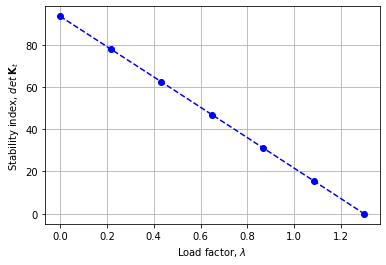

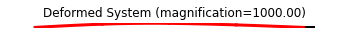

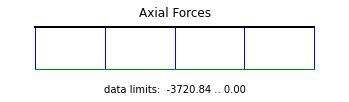

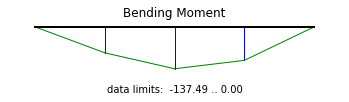

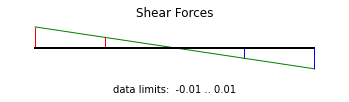

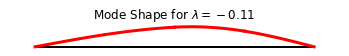

In [8]:
plt.plot(lambdas,detKt,'--ob')
plt.grid(True)
plt.xlabel('Load factor, $ \lambda $')
plt.ylabel("Stability index, $ {det}\: {\\bf K}_t $")
plt.show()

model.plot(factor=1000.0, filename="beam2_deformed.png")

model.beamValuePlot("F", filename="beam2_force.png")
model.beamValuePlot("M", filename="beam2_moment.png")
model.beamValuePlot("V", filename="beam2_shear.png")

model.plotBucklingMode(factor=10., filename="beam2_buckling_mode0.png")